## Modeling Methodology (Overview)
This notebook is a continuation of the Heart disease project. In the first notebook we did exploratory data analysis. The main takeaways were as follows:
- ### Numerical variables association with the target
    - **Strongest signals**  
      - `Oldpeak`: positive association with HeartDisease (strongest).  
      - `MaxHR`: negative association (second strongest).  
      - `Age`: positive association (moderate).  
    - **Weaker signals**  
      - `RestingBP`: small positive effect. (Due to the negligible `RestingBP` effect, we shall not consider it as part of the modelling process.)
      - `Cholesterol`: negative correlation, but unreliable due to zeros. (Special treatment for this to be explained below)
    - **Polynomial/spline features** might be beneficial for some variables in the modeling stage.
- ### Categorical variables association with the target
    - Prioritize **ST_Slope**, **ChestPainType**, **ExerciseAngina**; include **Sex** and **FastingBS** as supportive predictors.
    - **RestingECG** is a candidate for exclusion in parsimonious specs.

#### Objective. 
Prioritize high recall for heart-disease detection while maintaining reasonable precision.

#### Data splits. 
Train/validation/test with stratification $(\approx 55\%$ positive / $45\% $ negative). Validation is used for threshold selection; test is held out for final reporting.

#### Pipelines & leakage control. 
All preprocessing (imputation, scaling, one-hot encoding, polynomial features, custom binning/cleaning) is encapsulated in scikit-learn Pipeline/ColumnTransformer objects and tuned within cross-validation, preventing data leakage.

#### Model families.

- Logistic Regression (L2 regularisation): Baseline, interpretable; tuned over C.

- Random Forests: Non-linear benchmark; tuned over trees/feature sampling/leaf size (variance-controlled settings).

#### Selection metrics. 
Use F2 to emphasize recall during model selection, and log auxiliary metrics (precision, roc_auc, accuracy). 

#### Threshold tuning. 
After choosing a model, set the operating threshold on the validation set (via TunedThresholdClassifierCV) to meet the recall target while monitoring precision/specificity.

#### Reporting. 
Present cross-validated metrics, validation threshold, confusion matrices, and PR/ROC curves; finalize on test set once.

In [5]:
import os, json
import sys
import ast

from joblib import dump
import sklearn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import ( OneHotEncoder,PolynomialFeatures, RobustScaler,PowerTransformer)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import (
    StratifiedKFold,
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    learning_curve,
    TunedThresholdClassifierCV,  
)

from sklearn.inspection import permutation_importance
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    fbeta_score,
    make_scorer,
    roc_auc_score,
    average_precision_score,
    brier_score_loss,
    log_loss,
    precision_recall_curve,
    roc_curve,
    classification_report,
confusion_matrix, ConfusionMatrixDisplay

)

# custom transformers and other useful functions for summaries down the line
sys.path.append(os.path.abspath(".."))
from utils.data_utils import (
    CholesterolCleaner,
    PolynomialFeatureAdder,
    OldpeakBinner,ThresholdWrapper,show_dist,
ToDataFrame, plot_perm_importance_box,summarize_tuned, plot_confusion_matrices_grid
)


### Data Loading & Stratified Split

We load the training features and labels, combine them for quick inspection, and create a stratified train/validation split to preserve the class balance of the target:

- Files: `training_features.csv` (predictors), `training_labels.csv` (binary target `HeartDisease`)

- Dimensions: Modeling dataset: 734 rows × 9 columns

- Split: 75% train (550 observations) / 25% (184 observations) validation with `stratify=y `
All preprocessing and modeling steps operate within scikit-learn Pipeline/ColumnTransformer objects to prevent leakage across these splits.

We check the stratification results to be sure: we print counts and percentages in each split to confirm that the $\approx 55%$ positive / 45% negative class ratio is preserved

The code below performs the split and verifies the target distribution in both subsets.

In [2]:
random_state = 2803
X_data =  pd.read_csv("../data/training_features.csv").drop(columns=["RestingBP","RestingECG"])
y = pd.read_csv("../data/training_labels.csv")
print("Dimensions of data: ", X_data.shape)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_data, y, test_size=0.25, stratify=y, random_state=random_state
)
print("\nTarget distribution — TRAIN")
print(show_dist(y_train))
print("\nTarget distribution — VALIDATION")
print(show_dist(y_valid))

Dimensions of data:  (734, 9)

Target distribution — TRAIN
              count  percent
HeartDisease                
0               246    44.73
1               304    55.27

Target distribution — VALIDATION
              count  percent
HeartDisease                
0                82    44.57
1               102    55.43


In [3]:
y_train = y_train.to_numpy().reshape(-1)
numerical_vars = ['Age','Cholesterol','MaxHR','Oldpeak']
categorical_vars = ['Sex','ChestPainType', 'FastingBS', 'ExerciseAngina', 'ST_Slope']

## Feature Sets

- All pipelines begin with CholesterolCleaner (treat Cholesterol == 0 as missing then we impute with the fold-specific median).
- Numerics are scaled with RobustScaler (this just ensures the scaling is not affect by outliers significantly); categoricals are encoded with OneHotEncoder(handle_unknown="ignore").
- The Oldpeak variable had a somewhat skewed distribution. We will have the following variations in the feature:

    -  leave as is
    -  perform a power transformation
    -  bin it

The feature sets are as follows then:
#### Baseline - baseline

- Oldpeak: untouched (continuous).

- Numerics: RobustScaler.

- Categoricals: one-hot.

- So this is a clean baseline with minimal assumptions about Oldpeak nonlinearity.

#### Oldpeak Yeo–Johnson - oldpeak_yj

- Oldpeak: Yeo–Johnson transform (standardize=False), then RobustScaler.

- Other numerics: RobustScaler.

- Categoricals: one-hot.

- The reasoning here is to tame Oldpeak's right-tail skew identified in EDA.

#### Polynomials (Oldpeak untouched) - poly_all

- Polynomials: add polynomial/interaction terms for all numeric features including Oldpeak as-is.

- Numerics: RobustScaler after expansion.

- Categoricals: one-hot.

- We attempt to capture nonlinearities without transforming Oldpeak.

#### Oldpeak YJ then Polynomials - oldpeak_yj_poly

- Oldpeak: Yeo–Johnson first (standardize=False).

- Polynomials: build polynomial/interaction terms on the transformed numerics.

- Numerics: RobustScaler; Categoricals: one-hot.

- We de-skew Oldpeak before squaring/interacting so derived terms are well-behaved.

#### No Cholesterol + Oldpeak YJ then Polynomials - no_chol_oldpeak_yj_poly

- Drop Cholesterol.

- Oldpeak: Yeo–Johnson (standardize=False).

- Polynomials: on remaining numerics (degree = deg).

- Numerics: RobustScaler; Categoricals: one-hot.

- Why: removes a noisy feature while keeping targeted nonlinearity. 

#### Oldpeak Binned + Polynomials (others only) - oldpeak_binned_poly

- Oldpeak: create Oldpeak_bin via fixed cutpoints.

- Polynomials: on other numeric features (exclude Oldpeak).

- Numerics: RobustScaler; Categoricals: one-hot (including Oldpeak_bin).

- So here we get discrete  tiers from Oldpeak while still allowing nonlinear interactions among the remaining continuous predictors.

The summary is shown below. 

| # | Feature set (pipeline key) | Oldpeak handling | Cholesterol | Polynomial features | Numeric scaling | Categorical encoding | Why/Notes |
|---|----------------------------|------------------|-------------|---------------------|-----------------|----------------------|-----------|
| 1 | **Baseline** (`baseline`) | Untouched (continuous) | Kept; zeros cleaned by **CholesterolCleaner** | None | **RobustScaler** (after median impute) | **OneHotEncoder** (`handle_unknown="ignore"`) | Minimal assumptions; clean baseline. |
| 2 | **Oldpeak YJ** (`oldpeak_yj`) | **Yeo–Johnson** (`standardize=False`) | Kept; zeros cleaned | None | **RobustScaler** | **OneHotEncoder** | De-skews right tail in `Oldpeak` seen in EDA. |
| 3 | **Polynomials (all numerics)** (`poly_all`) | Untouched | Kept; zeros cleaned | **Yes** (degree = `deg`) on all numerics | **RobustScaler** (post-expansion) | **OneHotEncoder** | Captures nonlinearities without transforming `Oldpeak`. |
| 4 | **Oldpeak YJ → Polynomials** (`oldpeak_yj_poly`) | **YJ first**, then polys | Kept; zeros cleaned | **Yes** (degree = `deg`) on transformed numerics | **RobustScaler** | **OneHotEncoder** | Makes derived terms from `Oldpeak` well-behaved before squaring/interaction. |
| 5 | **No Chol + Oldpeak YJ → Polynomials** (`no_chol_oldpeak_yj_poly`) | **YJ**, then polys | **Dropped** | **Yes** (degree = `deg`) on remaining numerics | **RobustScaler** | **OneHotEncoder** | Removes noisy `Cholesterol`; keeps targeted nonlinearity. |
| 6 | **Oldpeak binned + Polynomials (others)** (`oldpeak_binned_poly`) | Create **`Oldpeak_bin`** (fixed cutpoints); keep continuous `Oldpeak` | Kept; zeros cleaned | **Yes** (degree = `deg`) on numerics **excluding `Oldpeak`** | **RobustScaler** | **OneHotEncoder** (includes `Oldpeak_bin`) | Discrete risk tiers from `Oldpeak` + interactions among other continuous predictors. |

_Notes:_ All pipelines begin with **`CholesterolCleaner`** (treat `Cholesterol == 0` as missing → impute median within CV). Numeric preprocessing uses median imputation followed by **RobustScaler**. Categorical encoding uses **OneHotEncoder** with `handle_unknown="ignore"`.


In [6]:
deg = 2
# Numeric pipelines

num_basic = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("scaler", RobustScaler())
])

prep_1 = ColumnTransformer([
    ("num", num_basic, numerical_vars),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_vars),
], remainder="drop")


#prep 2: YJ-transform Oldpeak
num_rest = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("scaler", RobustScaler()),
])

oldpeak_only = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("yj", PowerTransformer(method="yeo-johnson", standardize=False)), 
    ("scaler", RobustScaler()),
])

prep_2 = ColumnTransformer([
    ("oldpeak", oldpeak_only, ["Oldpeak"]),
    ("num_rest", num_rest, [c for c in numerical_vars if c != "Oldpeak"]),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_vars),
], remainder="drop")


In [21]:
def numeric_selector_after_poly(df):
    return [c for c in df.columns if c not in categorical_vars]
poly_adder_all = PolynomialFeatureAdder(feature_names=numerical_vars, degree=deg)

#prep 3: polynomials with Oldpeak untouched

prep_3 = Pipeline([
    ("poly_add", poly_adder_all),
    ("ct", ColumnTransformer([
        ("num", num_basic, numeric_selector_after_poly),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_vars),
    ], remainder="drop")),
])

#prep 4: transform Oldpeak then introduce polynomial terms
oldpeak_then_passthrough = ColumnTransformer([
    ("yj_oldpeak",
        Pipeline([
            ("imp", SimpleImputer(strategy="median")),               
            ("yj", PowerTransformer(method="yeo-johnson", standardize=False)),
        ]),
        ["Oldpeak"]
    ),
    ("num_rest_passthrough",
        SimpleImputer(strategy="median"),                           
        [c for c in numerical_vars if c != "Oldpeak"]
    ),
    ("cat_passthrough", "passthrough", categorical_vars),
], remainder="drop")

columns_after_stage = (
    ["Oldpeak"] + [c for c in numerical_vars if c != "Oldpeak"] + categorical_vars
)

prep_4 = Pipeline([
    ("stage0", oldpeak_then_passthrough),
    ("to_df", ToDataFrame(columns=columns_after_stage)),
    ("poly_add", PolynomialFeatureAdder(
        feature_names=numerical_vars,   
        degree=deg
    )),
    ("ct", ColumnTransformer([
        ("num", num_basic, numeric_selector_after_poly),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_vars),
    ], remainder="drop")),
])
#----------------------------------------------------

#prep_5: yj-transform oldpeak, then remove cholesterol, then introduce polynomial terms, scale, ohe categorical variables.
#first yj transform oldpeak
#after polynomial expansion, select "numeric" columns by excluding categoricals
def numeric_selector_after_poly_nochol(df):
    return [c for c in df.columns if c not in categorical_vars]

num_no_chol = [c for c in numerical_vars if c != "Cholesterol"]
num_no_chol_no_oldpeak = [c for c in num_no_chol if c != "Oldpeak"]

stage_a = ColumnTransformer([
    ("oldpeak_yj",
        Pipeline([
            ("imp", SimpleImputer(strategy="median")),
            ("yj", PowerTransformer(method="yeo-johnson", standardize=False)),
        ]),
        ["Oldpeak"]
    ),
    ("num_rest_imp",
        SimpleImputer(strategy="median"),
        num_no_chol_no_oldpeak
    ),
    ("cat_passthrough", "passthrough", categorical_vars),
], remainder="drop")

#here we have column order after stage A: YJ-Oldpeak and the rest of numerics (but no Cholesterol) + cats
stage_a_columns = ["Oldpeak"] + num_no_chol_no_oldpeak + categorical_vars

prep_5 = Pipeline([
    ("stage_a", stage_a),
    ("to_df", ToDataFrame(columns=stage_a_columns)),  
    ("poly_add", PolynomialFeatureAdder(
        feature_names=num_no_chol, 
        degree=deg
    )),
    ("ct", ColumnTransformer([
        ("num", Pipeline([("scaler", RobustScaler())]),
            numeric_selector_after_poly),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False),
            categorical_vars),
    ], remainder="drop")),
])


#prep_6: we bin Oldpeak, treat it as a categorical varibale. then we introduce polynomial terms to the rest numerical vars, scale them, ohe categoricals
poly_targets = [c for c in numerical_vars if c != "Oldpeak"]

poly_adder_no_oldpeak = PolynomialFeatureAdder(feature_names=poly_targets,degree=deg)

def numeric_selector_after_poly_no_oldpeak(df):
    return [c for c in df.columns if c not in (categorical_vars + ["Oldpeak_bin"])]

prep_6 = Pipeline([
    ("oldpeak_bin", OldpeakBinner(col="Oldpeak", new_col="Oldpeak_bin")),  
    ("poly_add", poly_adder_no_oldpeak),
    ("ct", ColumnTransformer([
        ("num", num_basic, numeric_selector_after_poly_no_oldpeak),        
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False),
                categorical_vars + ["Oldpeak_bin"]),
    ], remainder="drop"))
])


In [63]:
LogisticRegBase = LogisticRegression(penalty="l2",max_iter=10_000,solver="liblinear")


# feature-set pipelines for logistic regression
feature_set_pipelines = {
    # baseline:cleaned cholesterol, usual imputation, scaling, ohe
    "baseline": Pipeline([
        ("chol_clean", CholesterolCleaner()), 
        ("prep", prep_1),                      
        ("clf", LogisticRegBase)
    ]),

    #Oldpeak YJ transormed, cleaned cholesterol, no polynomial terms, 
    "oldpeak_yj": Pipeline([
        ("chol_clean", CholesterolCleaner()),
        ("prep", prep_2),                      
        ("clf", LogisticRegBase)
    ]),

    #cleaned cholesterol, original Oldpeak, but polynomial terms added, scale numerics, ohe categoricals
    "poly_all": Pipeline([
        ("chol_clean", CholesterolCleaner()),
        ("prep", prep_3),                      
        ("clf", LogisticRegBase)
    ]),

    # cleaned cholesterol, transformed Oldpeak, but polynomial terms added, scale numerics, ohe categoricals
    "oldpeak_yj_poly": Pipeline([
        ("chol_clean", CholesterolCleaner()),
        ("prep", prep_4),                       
        ("clf", LogisticRegBase)
   ]),

    # no Cholesterol, transformed Oldpeak, but polynomial terms added, scale numerics, ohe categoricals
    "no_chol_oldpeak_yj_poly": Pipeline([
        #("chol_clean", CholesterolCleaner()),
        ("prep", prep_5),                       
        ("clf", LogisticRegBase)
    ]),

     #cleaned cholesterol Oldpeak binned, polynomial terms added, scale numerics, ohe categoricals
    "oldpeak_binned_poly": Pipeline([
       ("chol_clean", CholesterolCleaner()),
       ("prep", prep_6),                       # impute→bin Oldpeak; polys on others; scale + OHE
       ("clf", LogisticRegBase)
   ]),
}



### Logistic Regression Model Setup

We fit **L2-regularized** logistic regressions for each feature set and tune the inverse regularization strength `C` over
$[10^{-4},\,10^{-3},\,10^{-2},\,0.1,\,0.5,\,1,\,10]$.
Recall that \(C\) is the inverse of the regularization strength, so **smaller `C`** means **stronger** regularization.

---
Our objective is to prioritize **recall** (catch as many true heart-disease cases as possible) while still discouraging excessive false alarms. Prioritizing recall can reduce precision, so we select models by the $F_\beta$ score with $\beta=2$ (the **F2** score), which weights recall more heavily than precision without rewarding the trivial “predict everything positive” strategy that pure recall would.

---
For each feature set, we run a **5-fold stratified** grid search with a multi-metric scorer. We **refit on `f2`** to pick the winner and also record `recall`, `precision`, `roc_auc`, and `accuracy` to show trade-offs.

Because the class distribution is roughly **55% positive / 45% negative**, we do not apply class weighting or resampling by default.

The table **`leaderboard_results`** ranks models by `cv_f2` (and breaks ties by `cv_recall`) and reports, for each feature set, the selected `C` and cross-validated metrics.


In [64]:
param_grid = {"clf__C": [1e-4, 1e-3, 1e-2, 0.1, 0.5, 1, 10]}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
f2_beta =make_scorer(fbeta_score, beta=2)
scoring = {"f2": f2_beta , "pr_auc": "average_precision","precision":"precision", "recall":"recall", "roc_auc":"roc_auc", "accuracy": "accuracy"}

LR_results = {}
LR_models = {}
for name, pipe in feature_set_pipelines.items():
    grid = GridSearchCV(
        pipe,
        param_grid=param_grid,
        scoring=scoring,
        refit="f2",              # pick best by f2
        cv=cv,
        return_train_score=True,
    )
    grid.fit(X_train, y_train)

    i = grid.best_index_
    LR_models[name] = {"model": grid.best_estimator_ }
    LR_results[name] = {
        "C": grid.best_params_["clf__C"],
        "cv_f2": grid.cv_results_["mean_test_f2"][i],
        "cv_f2_std":    grid.cv_results_["std_test_f2"][i],   
        "cv_recall":   grid.cv_results_["mean_test_recall"][i],
        "cv_recall_std":   grid.cv_results_["std_test_recall"][i],
        "train_recall":grid.cv_results_["mean_train_recall"][i],
        "cv_auc":      grid.cv_results_["mean_test_roc_auc"][i],
        "cv_pr_auc":    grid.cv_results_["mean_test_pr_auc"][i],
        "cv_precision":grid.cv_results_["mean_test_precision"][i],
        "cv_accuracy": grid.cv_results_["mean_test_accuracy"][i],
    }

leaderboard_Results = (
    pd.DataFrame(LR_results).T
      .sort_values(["cv_f2","cv_recall"], ascending=[False, False])
      .round(4)
)


In [65]:
leaderboard_Results

,C,cv_f2,cv_f2_std,cv_recall,cv_recall_std,train_recall,cv_auc,cv_pr_auc,cv_precision,cv_accuracy
baseline,0.001,0.8946,0.0205,0.9211,0.0216,0.9211,0.9096,0.9124,0.8024,0.8309
oldpeak_yj,0.001,0.8940,0.0202,0.9211,0.0216,0.9186,0.9080,0.9087,0.8000,0.8291
oldpeak_binned_poly,0.500,0.8883,0.0289,0.8948,0.0303,0.9063,0.9261,0.9295,0.8636,0.8636
no_chol_oldpeak_yj_poly,0.100,0.8863,0.0178,0.8980,0.0194,0.8947,0.9176,0.9244,0.8425,0.8509
oldpeak_yj_poly,0.100,0.8847,0.0205,0.8946,0.0228,0.9013,0.9182,0.9187,0.8472,0.8527
poly_all,0.100,0.8821,0.0202,0.8914,0.0224,0.8972,0.9203,0.9237,0.8467,0.8509


### Results discussion
- Winner by `F2`. baseline is top on `cv_f2` (`0.8946`). All others are within $~1$ standard deviation, so performance is statistically comparable.

- **Recall** focus. `baseline` and `oldpeak_yj` tie on mean recall (0.9211) and show low fold variance; furthermore, train_recall $\approx$ cv_recall, suggesting little overfitting.

- **Precision and accuracy angle**. `oldpeak_binned_poly` leads on precision (`0.8636`), PR-AUC (`0.9295`), ROC AUC (`0.9261`), and accuracy (`0.8636`), but gives up recall (`0.8948`) and has higher variance for recall, compared to  `baseline` and `oldpeak_yj`. 

So briefly:
- For a recall-prioritizing brief, our Champion is the `baseline`. It has the best `F2`, and tied-best recall. Furthermore, it is stable and the simplest.

- However, as a backup incase stakeholders prefer fewer false positives: we could turn to `oldpeak_binned_poly`. It has Higher precision/PR AUC/accuracy with modest recall loss (and a bit more variance).


### Feature importance using F2 - **Baseline** model
Permutation importance on the **validation** set (scored by **F2** at the default 0.5 threshold):

- **ST_Slope** - strongest signal: mean drop $\approx 0.037\ (\pm 0.014)$. Shuffling it hurts F2 the most → main driver of catching positives.
- **Oldpeak** - moderate: $\approx 0.017\ (\pm 0.012)$.
- **ChestPainType** - moderate: $\approx 0.016\ (\pm 0.013)$.

These three are the only features whose means noticeably exceed their own standard deviations. The remaining features are effectively **neutral** (means near $0$ relative to their variability).  


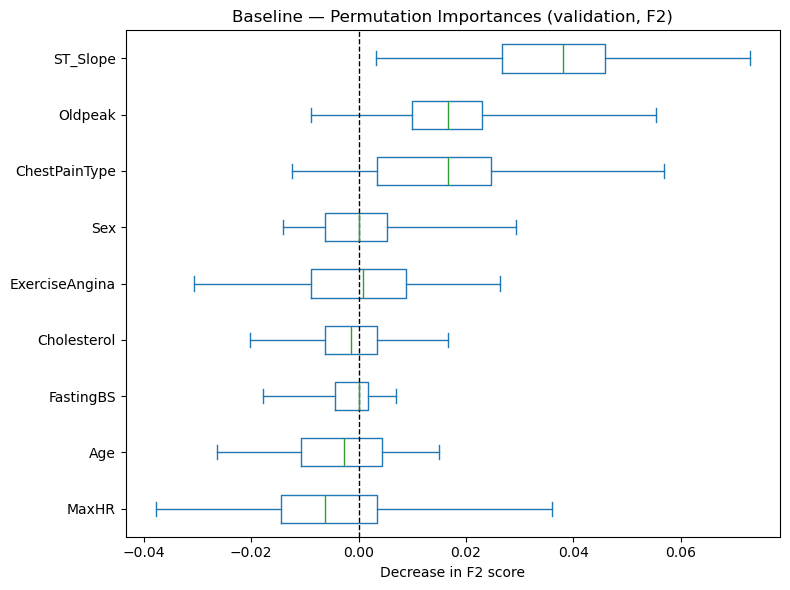

In [26]:
baseline_model = LR_models["baseline"]["model"]
oldpeak_binned_poly = LR_models["oldpeak_binned_poly"]["model"]

feat_importance_baseline = permutation_importance(
    baseline_model, X_valid, y_valid,
    scoring=f2_beta, n_repeats=100, random_state=random_state, n_jobs=-1
)

feat_names = getattr(X_valid, "columns", np.arange(X_valid.shape[1]).astype(str))
feat_importance_baseline_df = (
    pd.DataFrame({
        "feature": feat_names,
        "importance_mean": feat_importance_baseline.importances_mean,
        "importance_std":  feat_importance_baseline.importances_std,
    })
    .sort_values("importance_mean", ascending=False)
    .reset_index(drop=True)
)
plot_perm_importance_box(
    feat_importance_baseline,
    feat_names,
    title="Baseline — Permutation Importances (validation, F2)",
    xlabel="Decrease in F2 score"
)

In [468]:
print(feat_importance_baseline_df)

           feature  importance_mean  importance_std
0         ST_Slope         0.037023        0.014073
1          Oldpeak         0.017361        0.012017
2    ChestPainType         0.015580        0.013497
3              Sex         0.000433        0.009468
4        RestingBP         0.000000        0.000000
5       RestingECG         0.000000        0.000000
6   ExerciseAngina        -0.000080        0.011792
7      Cholesterol        -0.001172        0.007806
8        FastingBS        -0.001413        0.004916
9              Age        -0.003874        0.009647
10           MaxHR        -0.005319        0.013040


### Feature importance using F2 — **oldpeak\_binned\_poly** model
(Validation set, F2)

- **ST\_Slope** — dominant: $0.096 \pm 0.022$ (stronger effect than in baseline).
- **ChestPainType** — strong: $0.072 \pm 0.018$.
- **FastingBS** — meaningful here: $0.040 \pm 0.010$ (near-zero in baseline).
- **Sex** ($0.029 \pm 0.015$) and **ExerciseAngina** ($0.023 \pm 0.012$) are now clearly positive ($\approx0$ in baseline).
- **Oldpeak** — modest: $0.009 \pm 0.012$. With **Oldpeak** binned in this pipeline, much of its signal flows through the bin feature rather than the raw value.

In this engineered pipeline, categorical/bin features (e.g., ST\_Slope, ChestPainType, FastingBS, ExerciseAngina) carry more of the predictive load. Furthermore, these results align with EDA: `ST_Slope` and `ChestPainType` were among the strongest associations with the target.


**Notes.**
- Permutation importance is **metric- and threshold-dependent**; these reflect F2 at the model's default 0.5 threshold on **validation**.


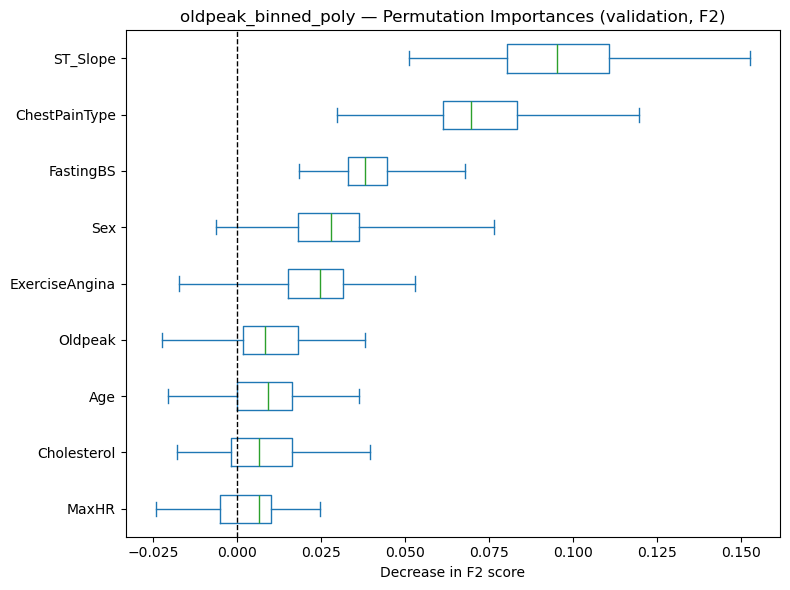

In [28]:
oldpeak_binned_poly = LR_models["oldpeak_binned_poly"]["model"]

feat_importance_oldpeak_binned_poly = permutation_importance(
    oldpeak_binned_poly, X_valid, y_valid,
    scoring=f2_beta, n_repeats=100, random_state=random_state, n_jobs=-1
)

feat_names = getattr(X_valid, "columns", np.arange(X_valid.shape[1]).astype(str))
feat_importance_oldpeak_binned_poly_df = (
    pd.DataFrame({
        "feature": feat_names,
        "importance_mean": feat_importance_oldpeak_binned_poly.importances_mean,
        "importance_std":  feat_importance_oldpeak_binned_poly.importances_std,
    })
    .sort_values("importance_mean", ascending=False)
    .reset_index(drop=True)
)
plot_perm_importance_box(
    feat_importance_oldpeak_binned_poly,
    feat_names,
    title="oldpeak_binned_poly — Permutation Importances (validation, F2)",
    xlabel="Decrease in F2 score"
)

In [472]:
print(feat_importance_oldpeak_binned_poly_df)

           feature  importance_mean  importance_std
0         ST_Slope         0.095859        0.021620
1    ChestPainType         0.072192        0.017734
2        FastingBS         0.039669        0.010424
3              Sex         0.029312        0.015090
4   ExerciseAngina         0.022787        0.012135
5          Oldpeak         0.009196        0.012369
6              Age         0.008656        0.011899
7      Cholesterol         0.007288        0.011681
8            MaxHR         0.003423        0.010611
9       RestingECG         0.000000        0.000000
10       RestingBP         0.000000        0.000000


### Random Forest Model Setup

We train **Random Forest classifiers** for each feature set (one pipeline per feature set in `rf_pipelines`) and tune three hyperparameters:

- **`n_estimators`** $ \in \{100, 300, 500, 700, 1000\}  $
  Number of trees. More trees typically reduce variance (with diminishing returns) at higher compute cost.

- **`max_features`** $ \in \{$`sqrt`, `log2` $ \}  $
  Number of features considered at each split. Smaller values decorrelate trees, often improving generalization.

- **`min_samples_leaf`** $ \in \{10, 20, 30, 50\}  $ 
  Minimum samples per leaf. Acts as a **regularizer**-larger leaves curb overfitting and produce smoother decisions. So it creates more reliable leaves-often stabilizing recall.

---

As before We prioritize **recall** (catch true heart-disease cases).

We refit on **`f2`** after the grid search to pick each feature-set winner.

---

### Cross-Validation

For each pipeline in `rf_pipelines`, we run a **stratified** K-fold grid search with a **multi-metric** scorer.
In addition to `f2`, we log complementary metrics to surface trade-offs:

- **`cv_f2`**, **`cv_f2_std`** — selection metric (mean ± std across folds)  
- **`cv_recall`**, **`cv_recall_std`** — sensitivity on CV folds  
- **`train_recall`** — quick overfitting check against CV recall  
- **`cv_precision`**, **`cv_accuracy`**, **`cv_auc`** — complementary views (specificity/overall/ ranking quality)

As before, we assemble `leaderboard_random_forests` and **rank by `cv_f2` (tie-break on `cv_recall`)**:


In [66]:
# we use same feature sets as before, so we use the pipelines from before for Random Forest as the classifier
rf_base = RandomForestClassifier(
    n_estimators=300,          
    max_features="sqrt",
    min_samples_leaf=10,
    n_jobs=-1,
    random_state=random_state
)
rf_pipelines = {
    name: Pipeline([
        ("chol_clean", CholesterolCleaner()),
        ("prep", pipe.named_steps["prep"]),    
        ("clf", clone(rf_base))
    ])
    for name, pipe in feature_set_pipelines.items()
}


In [67]:
param_grid_rf = {
    "clf__n_estimators":  [50, 100, 300, 500, 700],
    "clf__max_features":  ["sqrt", "log2"],  
    "clf__min_samples_leaf": [ 10, 20, 30, 50]
}


rf_results = {}
random_forests_models = {}

for name, pipe in rf_pipelines.items():
    grid = GridSearchCV(
        pipe,
        param_grid=param_grid_rf,
        scoring=scoring,
        refit="f2",          
        cv=cv,
        n_jobs=-1,              
        return_train_score=True,
    )
    grid.fit(X_train, y_train)

    i = grid.best_index_
    random_forests_models[name] = {"model": grid.best_estimator_}
    rf_results[name] = {
        "n_estimators":   grid.best_params_["clf__n_estimators"],
        "max_features":   grid.best_params_["clf__max_features"],
        "min_samples_leaf": grid.best_params_["clf__min_samples_leaf"],
        "cv_f2": grid.cv_results_["mean_test_f2"][i].round(3),
        "cv_f2_std":    grid.cv_results_["std_test_f2"][i],
        "cv_recall":   grid.cv_results_["mean_test_recall"][i].round(3),
         "cv_recall_std":   grid.cv_results_["std_test_recall"][i],
        "train_recall":grid.cv_results_["mean_train_recall"][i].round(3),
        "cv_auc":         grid.cv_results_["mean_test_roc_auc"][i].round(3),
        "cv_precision":   grid.cv_results_["mean_test_precision"][i].round(3),
        "cv_accuracy":    grid.cv_results_["mean_test_accuracy"][i].round(3),
    }

leaderboard_random_forests = (
    pd.DataFrame(rf_results).T
      .sort_values(["cv_f2", "cv_recall"], ascending=[False, False])
)



### Random Forests - Results Discussion

Grid-search + 5-fold CV results are summarised below. Key takeaways:

- **$F_2$ parity.** All models'$F_2$ scores are effectively tied: each lies within **1 SD** of the top $F_2$ ($0.899$ for `oldpeak_yj_poly`, SD $\approx 0.008$). In other words, no RF variant clearly dominates on the primary objective.

- **Recall parity.** The best mean recall is $0.914$ (`oldpeak_yj_poly`, `poly_all` and `no_chol_oldpeak_yj_poly`: SD $\approx 0.012$). All others fall within about one SD of this (roughly $0.902$–$0.926$ in our table), again suggesting no material separation on recall.

- **Secondary metrics favour `baseline`.** Despite similar $F_2$/recall, `baseline` has the highest ROC AUC ($0.923$), precision ($0.848$), and accuracy ($0.860$) among the RFs (although `oldpeak_yj_poly` also has similar results, just off by a bit). That points to a more balanced operating profile with fewer false alarms for a modest (statistically negligible) recall trade-off. 

- **Overfitting check.** For all models, $\texttt{train\_recall} \approx \texttt{cv\_recall}$, indicating minimal overfitting. Note that `baseline` shows a slightly larger fold variability in $F_2$ (SD $\approx 0.015$) than some others, but still within comfortable bounds.

**Decision for next stage.** Because the primary metrics are statistically indistinguishable, we proceed with two RF candidates:
- `oldpeak_yj_poly` — nominal top $F_2$/recall.
- `baseline` — strongest secondary metrics (ROC AUC, precision, accuracy) and simplest feature set.

These will undergo threshold tuning and validation-set evaluation alongside the logistic-regression champions.


In [68]:
leaderboard_random_forests

,n_estimators,max_features,min_samples_leaf,cv_f2,cv_f2_std,cv_recall,cv_recall_std,train_recall,cv_auc,cv_precision,cv_accuracy
oldpeak_yj_poly,100,log2,10,0.899,0.008319,0.914,0.012207,0.919,0.916,0.84,0.856
poly_all,700,sqrt,20,0.897,0.007864,0.914,0.012207,0.918,0.91,0.835,0.853
no_chol_oldpeak_yj_poly,500,sqrt,20,0.897,0.007864,0.914,0.012207,0.911,0.912,0.835,0.853
baseline,300,sqrt,10,0.897,0.015266,0.911,0.02019,0.91,0.923,0.848,0.86
oldpeak_binned_poly,300,sqrt,30,0.896,0.005843,0.911,0.008449,0.909,0.908,0.84,0.855
oldpeak_yj,100,sqrt,20,0.894,0.021053,0.911,0.027341,0.914,0.918,0.835,0.851


### Feature Importances 
We investigate feature importances for the `oldpeak_yj_poly` random forest model

Top drivers in categorical fields:

- `ST_Slope_Up` (0.170) and `ST_Slope_Flat` (0.124) dominate. 

- `ChestPainType_ASY` (0.112) is next -'asymptomatic' chest pain is highly informative.

- `ExerciseAngina` (Y: 0.076, N: 0.055) also carries substantial weight (split across the two dummies).

This is unsurprising given the discoveries made during exploratory data analysis.

Key numeric effects:

- MaxHR$^2$ (0.043) and MaxHR (0.038) both matter suggesting strong nonlinear relationship with risk. 

- `Oldpeak` appears both alone and in combos: Oldpeak (0.039), Oldpeak$^2$ (0.034), MaxHR·Oldpeak (0.030), Cholesterol·Oldpeak (0.030), Age·Oldpeak (0.041). Oldpeak's interactions appear to be consistently important.

Cholesterol has smaller direct effect (0.016) but contributes via interactions (Age·Cholesterol 0.026, Cholesterol$^2$0.019, Cholesterol·MaxHR 0.017).

Other less signal-heavy features:

- Sex has modest but non-zero signal (F: 0.0138, M: 0.0130).

- `FastingBS` is low (1: 0.0121, 0: 0.0092).

- `ChestPainType_ATA/NAP` are smaller; TA ~ 0 suggests little unique signal beyond other features. This could be because they account for <25% of the observations

- ST_Slope_Down ~ 0 likely due to few samples or redundancy with Up/Flat.



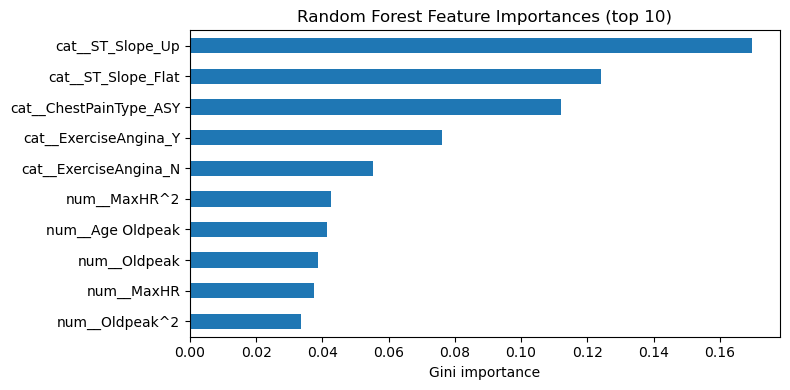

In [78]:
oldpeak_yj_poly_rf = random_forests_models["oldpeak_yj_poly"]["model"]
ct = oldpeak_yj_poly_rf.named_steps["prep"].named_steps["ct"]
feature_names = ct.get_feature_names_out()
rf = oldpeak_yj_poly_rf.named_steps["clf"]
importances = rf.feature_importances_
fi = pd.Series(importances, index=feature_names).sort_values(ascending=False)
top_n = 15
plt.figure(figsize=(8, max(4, 0.35*top_n)))
fi.head(top_n)[::-1].plot(kind="barh")
plt.xlabel("Gini importance")
plt.title(f"Random Forest Feature Importances (top {top_n})")
plt.tight_layout()
plt.show()

### Permutation feature impotance

For permutation feature importance we note the following: 

- ChestPainType_ASY is the only clearly robust signal (mean $\approx 0.0185$).

- ST_Slope_Up shows modest real-world lift ( $\approx 0.0114$).

- ExerciseAngina_Y is weak-positive ( $\approx 0.005$).

- Everything else hovers around ~0, with quite a few slightly negative means (e.g., Oldpeak, Oldpeak$^2$, MaxHR, MaxHR$^2$).

These results are unsurprising given that the Gini can overstate importance for high-cardinality/interaction-prone features and correlated families.

<Figure size 800x400 with 0 Axes>

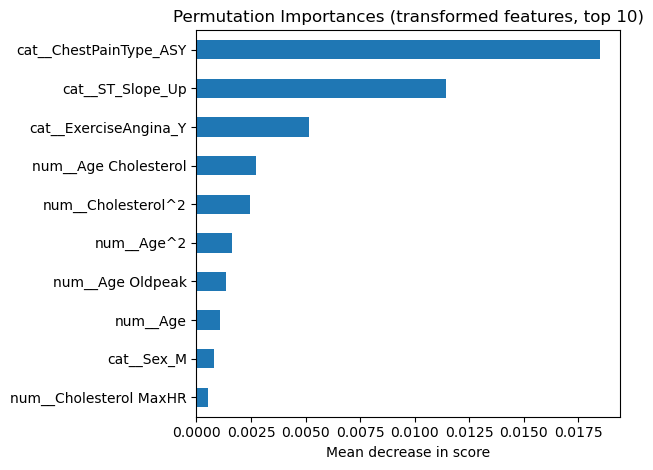

In [80]:
ct = oldpeak_yj_poly_rf.named_steps["prep"].named_steps["ct"]
feature_names = ct.get_feature_names_out()

Xt_valid = oldpeak_yj_poly_rf[:-1].transform(X_valid) 
rf = pipe.named_steps["clf"]

r = permutation_importance(
    rf, Xt_valid, y_valid,
    n_repeats=20, random_state=42, n_jobs=-1,
  
)
pi_df = (pd.DataFrame({
    "feature": feature_names,
    "perm_importance_mean": r.importances_mean,
    "perm_importance_std": r.importances_std
}).sort_values("perm_importance_mean", ascending=False))
top_n = 10
plt.figure(figsize=(8, max(4, 0.35*top_n)))
pi_df.head(top_n).iloc[::-1].plot(
    kind="barh", x="feature", y="perm_importance_mean", legend=False
)
plt.xlabel("Mean decrease in score")  
plt.ylabel("")
plt.title(f"Permutation Importances (transformed features, top {top_n})")
plt.tight_layout()
plt.show()

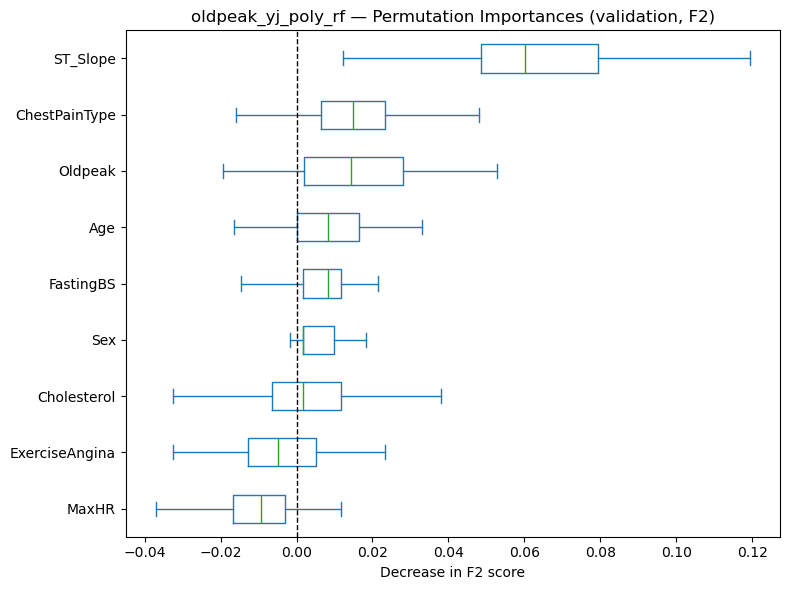

In [83]:
feat_importance_oldpeak_yj_poly_rf = permutation_importance(
    oldpeak_yj_poly_rf, X_valid, y_valid,
    scoring=f2_beta, n_repeats=100, random_state=random_state, n_jobs=-1
)
feature_names = list(X_valid.columns)

feat_importance_oldpeak_binned_poly_df = (
    pd.DataFrame({
        "feature": feature_names,
        "importance_mean": feat_importance_oldpeak_yj_poly_rf.importances_mean,
        "importance_std":  feat_importance_oldpeak_yj_poly_rf.importances_std,
    })
    .sort_values("importance_mean", ascending=False)
    .reset_index(drop=True)
)
plot_perm_importance_box(
    feat_importance_oldpeak_yj_poly_rf,
    feature_names,
    title="oldpeak_yj_poly_rf — Permutation Importances (validation, F2)",
    xlabel="Decrease in F2 score"
)


### Threshold Tuning

We now perform **threshold tuning** for the four candidate models:

- Logistic regression **baseline** (`baseline_model`)
- Logistic regression **oldpeak_binned_poly**
- Random forest **baseline** (`baseline_rf`)
- Random forest **oldpeak_yj_poly_rf**

We use `TunedThresholdClassifierCV` to find the decision threshold that **maximises the $F_2$ score**.  
Thresholds are tuned via the same stratified 5-fold CV (`cv`) as before, i.e., we **refit** using train-folds only and select the threshold that yields the highest mean $F_2$ across folds.

So in summary, these are our next steps:
1. For each model, tune the threshold by CV on the training data (objective: $F_2$).
2. Freeze the tuned threshold for that model.
3. Report **validation** metrics at the tuned threshold: **recall (positive class)**, **$F_2$**, **precision**, and **accuracy** (plus a confusion matrix).
4. Select the overall champion, then (later) refit on **train+validation**, re-tune the threshold on **train+validation**, and evaluate **once** on the test set.


In [89]:
baseline_model_classifier_tuned = TunedThresholdClassifierCV(
    baseline_model, scoring=f2_beta, cv=cv
).fit(X_train, y_train)

print(f"Cut-off point for LR baseline model: {baseline_model_classifier_tuned.best_threshold_:.3f}")

oldpeak_binned_poly_classifier_tuned = TunedThresholdClassifierCV(
    oldpeak_binned_poly, scoring=f2_beta, cv=cv
).fit(X_train, y_train)

print(f"Cut-off point for LR oldpeak_binned_poly model: {oldpeak_binned_poly_classifier_tuned.best_threshold_:.3f}")
#----------------------------------------------------------------------------------------------------------------------------
oldpeak_yj_poly_rf = random_forests_models["oldpeak_yj_poly"]["model"]
baseline_rf = random_forests_models["baseline"]["model"]

baseline_model_rf_classifier_tuned = TunedThresholdClassifierCV(
    baseline_rf, scoring=f2_beta, cv=cv
).fit(X_train, y_train)

print(f"Cut-off point for RF baseline model found at {baseline_model_rf_classifier_tuned.best_threshold_:.3f}")

oldpeak_yj_poly_rf_classifier_tuned = TunedThresholdClassifierCV(
    oldpeak_yj_poly_rf, scoring=f2_beta, cv=cv
).fit(X_train, y_train)

print(f"Cut-off point for RF oldpeak_yj_poly model found at {oldpeak_yj_poly_rf_classifier_tuned.best_threshold_:.3f}")

Cut-off point for LR baseline model: 0.483
Cut-off point for LR oldpeak_binned_poly model: 0.184
Cut-off point for RF baseline model found at 0.376
Cut-off point for RF oldpeak_yj_poly model found at 0.318


### Results of Tuned Models - Validation Set

The validation set has 184 observations (stratified split). Each model's decision threshold was tuned via CV on the training data to maximise $F_2$, then evaluated once on validation.

**Headline results (validation):**
- **RF `oldpeak_yj_poly (tuned)`** - best $F_2 = 0.9238$ and highest recall $= 0.9510$; second highest precision of $ 0.8291$, accuracy $= 0.8641$ (tied with RF baseline).
- **RF `baseline (tuned)`** - $F_2 = 0.9117$, recall $= 0.9314$, **higher precision** $= 0.8407$ and **tied accuracy** $= 0.8641$.
- **LR `baseline (tuned)`** - $F_2 = 0.9151$, recall $= 0.9510$, precision $= 0.7951$, accuracy $= 0.8370$.
- **LR `oldpeak_binned_poly (tuned)`** - $F_2 = 0.9040$, recall $= 0.9412$, precision $= 0.7805$, accuracy $= 0.8207$.


**Confusion Matrices**

Further below we have confusion matrices and row-normalized plots for each model:
 - Top row (Actual 0): entries are TN (left) and FP (right) (false alarms)
 - Bottom row (Actual 1): entries are FN (left) and TP (right) (missed positives vs caught positives)
 - In the row-normalized plots, each row sums to 1 so they directly show specificity (top-left) and recall (bottom-right).

We note the following regarding the models:
##### RF oldpeak_yj_poly (tuned)

 - Very few FN, many TP so recall is highest.
 - FP somewhat higher so precision and accuracy are lower.
 - This setting catches almost all positive cases but triggers more false alerts.

##### RF baseline (tuned)

 - Slightly fewer FP (more TN) than the above.
 - Slightly more FN so recall a bit lower.
 - More balanced: fewer false alarms at the cost of a few more misses.

##### LR baseline (tuned)

 - Typically sits between the two RFs: high recall with moderate FP.
 - High recall with more conservative FP than the most aggressive RF.

##### LR oldpeak_binned_poly (tuned)

 - Similar story to LR baseline but a touch more FP and FN (given your metrics).
 - No clear advantage over LR baseline at this operating point.

**Summary and decisions**
- The **RF `oldpeak_yj_poly`** variant pushes the operating point toward **very high recall**, accepting **more false positives** (lower precision/accuracy).  
- The **RF `baseline`** offers a slightly lower recall but **slightly better precision and accuracy**.  
- Within the LR family, **LR baseline** dominates its engineered counterpart on all reported metrics.
- We select **RF `oldpeak_yj_poly`** as the **champion**: it maintains **high recall** while delivering **acceptable precision and accuracy**, which better suits practical use when false positives carry cost.
- In practice, stakeholders might enforce a constraint (e.g., “maximise $F_2$ subject to precision $\ge 0.80$”). Under such a constraint, the chosen RF baseline meets the spirit of a **high-recall, acceptable-precision** operating point.

**Next steps.**
- Refit the champion on **train+validation**, re-tune the threshold on **train+validation**, then perform a **single** final evaluation on the **test** set (report recall, $F_2$, precision, accuracy + confusion matrix) in the next notebook.


                           model  threshold  recall  precision  accuracy  \
0            LR baseline (tuned)      0.483  0.9510     0.7951    0.8370   
1  LR oldpeak_binned_poly(tuned)      0.184  0.9412     0.7805    0.8207   
2            RF baseline (tuned)      0.376  0.9314     0.8407    0.8641   
3      RF oldpeak_yj_poly(tuned)      0.318  0.9510     0.8291    0.8641   

       F2  
0  0.9151  
1  0.9040  
2  0.9117  
3  0.9238  

------------------------------------------------------------------------------------------------------------------


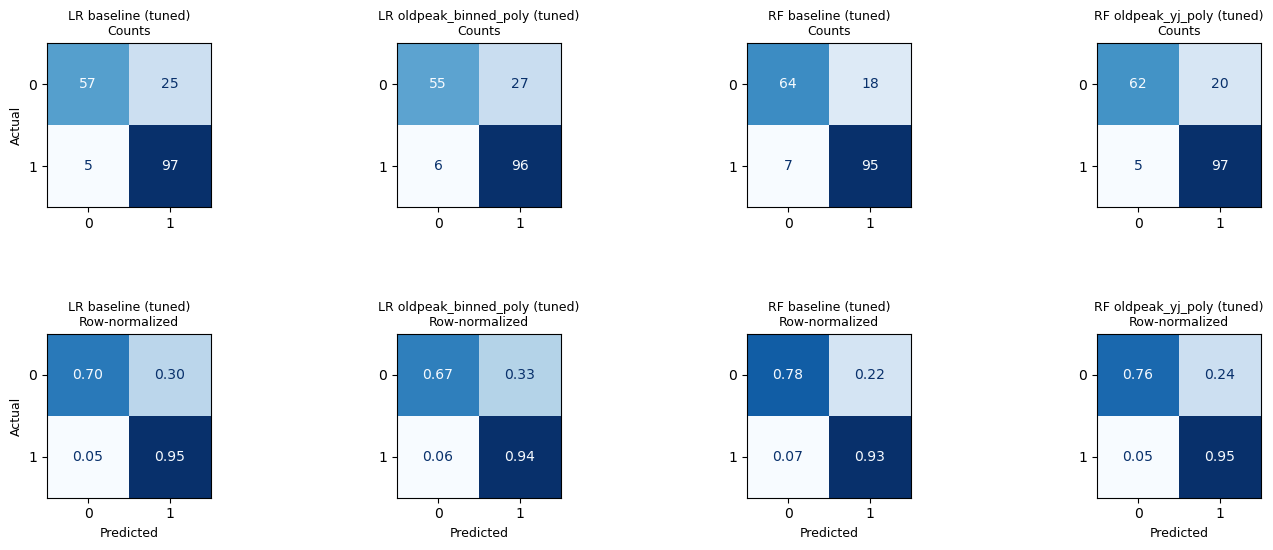

In [90]:
summary_val = pd.DataFrame([
    summarize_tuned("LR baseline (tuned)", baseline_model_classifier_tuned, X_valid, y_valid),
    summarize_tuned("LR oldpeak_binned_poly(tuned)", oldpeak_binned_poly_classifier_tuned, X_valid, y_valid),
    summarize_tuned("RF baseline (tuned)", baseline_model_rf_classifier_tuned, X_valid, y_valid),
    summarize_tuned("RF oldpeak_yj_poly(tuned)", oldpeak_yj_poly_rf_classifier_tuned, X_valid, y_valid),
]).round(4)

print(summary_val)
print("\n------------------------------------------------------------------------------------------------------------------")
models_tuned = [
    ("LR baseline (tuned)",            baseline_model_classifier_tuned),
    ("LR oldpeak_binned_poly (tuned)", oldpeak_binned_poly_classifier_tuned),
    ("RF baseline (tuned)",            baseline_model_rf_classifier_tuned),
    ("RF oldpeak_yj_poly (tuned)",     oldpeak_yj_poly_rf_classifier_tuned),
]

plot_confusion_matrices_grid(models_tuned, X_valid, y_valid, show=True)

In [91]:

champion_estimator = random_forests_models["oldpeak_yj_poly"]["model"] 
if not isinstance(y_train, pd.Series):
    y_train = pd.Series(np.asarray(y_train).ravel(), index=getattr(X_train, "index", None))

if isinstance(y_valid, pd.DataFrame):
    y_valid = y_valid.squeeze("columns")

X_trainval = pd.concat([X_train, X_valid], axis=0)
y_trainval = pd.concat([y_train, y_valid], axis=0)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
tuner = TunedThresholdClassifierCV(
    clone(champion_estimator), scoring=f2_beta, cv=cv
).fit(X_trainval, y_trainval)

best_t = float(tuner.best_threshold_)
print(f"Final threshold (Train+Validation, CV): {best_t:.3f}")
base_refit = clone(champion_estimator).fit(X_trainval, y_trainval)

final_model_tuned = ThresholdWrapper(base_refit, best_t)




Final threshold (Train+Validation, CV): 0.225


In [96]:
ARTI_DIR = "artifacts/final_oldpeak_yj_poly_tuned"   
os.makedirs(ARTI_DIR, exist_ok=True)
dump(base_refit, f"{ARTI_DIR}/pipeline.joblib")

with open(f"{ARTI_DIR}/threshold.json", "w") as f:
    json.dump({"best_threshold": float(best_t)}, f)
pd.Series(X_trainval.columns, name="columns").to_csv(f"{ARTI_DIR}/columns.csv", index=False)

meta = {
    "model_family": "RandomForest",           
    "feature_set": "baseline",                
    "objective": "F2 (beta=2)",
    "cv": {"n_splits": 5, "shuffle": True, "random_state": int(random_state)},
    "versions": {
        "sklearn": sklearn.__version__,
        "pandas": pd.__version__,
        "numpy": np.__version__,
    },
}
with open(f"{ARTI_DIR}/meta.json", "w") as f:
    json.dump(meta, f, indent=2)

print(f"Saved artifacts to: {ARTI_DIR}")


Saved artifacts to: artifacts/final_oldpeak_yj_poly_tuned
